In [66]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

import json
import pickle
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, StratifiedKFold
pd.set_option('max_columns', None)

url_matches_19_20 = 'https://api.opendota.com/api/explorer?sql=SELECT%0A%20%20%20%20%20%20%20%20%0Amatches.match_id%2C%0Amatches.start_time%2C%0A((player_matches.player_slot%20%3C%20128)%20%3D%20matches.radiant_win)%20win%2C%0Aplayer_matches.hero_id%2C%0Aplayer_matches.account_id%2C%0Aleagues.name%20leaguename%0AFROM%20matches%0AJOIN%20match_patch%20using(match_id)%0AJOIN%20leagues%20using(leagueid)%0AJOIN%20player_matches%20using(match_id)%0AJOIN%20heroes%20on%20heroes.id%20%3D%20player_matches.hero_id%0ALEFT%20JOIN%20notable_players%20ON%20notable_players.account_id%20%3D%20player_matches.account_id%0ALEFT%20JOIN%20teams%20using(team_id)%0AWHERE%20TRUE%0AAND%20matches.start_time%20%3E%3D%20extract(epoch%20from%20timestamp%20%272019-12-31T23%3A00%3A00.000Z%27)%0AAND%20matches.start_time%20%3C%3D%20extract(epoch%20from%20timestamp%20%272020-12-31T23%3A00%3A00.000Z%27)%0AAND%20leagues.tier%20%3D%20%27professional%27%0AORDER%20BY%20matches.match_id%20NULLS%20LAST%0ALIMIT%20999999'
url_base_match = 'https://api.opendota.com/api/matches/'

class DotaTeam:
    def __init__(self,name,wins,losses,winrate,skill,real,luck):
        self.name = name
        self.wins = wins
        self.losses = losses
        self.winrate = winrate
        self.skill = skill
        self.real = real
        self.luck = luck
    def __str__(self):
        return str(self.__dict__)
    def __repr__(self):
        return str(self)
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__,
            sort_keys=True, indent=4)

class DotaMatch:
    def __init__(self,match_id,radiant_score,dire_score,duration,first_blood_time,picks_bans,radiant_team,dire_team):
        self.match_id = match_id
        self.radiant_score = radiant_score
        self.dire_score = dire_score
        self.duration = duration
        self.first_blood_time = first_blood_time
        self.pick_bans = picks_bans
        self.radiant_team = radiant_team
        self.dire_team = dire_team
    def __str__(self):
        return str(self.__dict__)
    def __repr__(self):
        return str(self)
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__,
            sort_keys=True, indent=4)

def save_obj(obj, name):
    with open('./Data/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('./Data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [2]:
# Data Generation
r_all_matches_19_20 = requests.get(url_matches_19_20)

KeyboardInterrupt: 

In [ ]:
parsed_json_matches_19_20 = json.loads(r_all_matches_19_20.text)

list_matches_19_20 = []

In [ ]:
for match in parsed_json_matches_19_20['rows']:
    if match['match_id'] not in list_matches_19_20:
        list_matches_19_20.append(match['match_id'])
print('Number of Matches: ', len(list_matches_19_20))

In [ ]:
fetch_counter = 1
matchdata_TI19 = []
for match in list_matches_19_20:
    # r = requests.get(url)
    matchdata_response = requests.get(url_base_match + str(match))
    if matchdata_response.status_code == 200:
        matchdata_TI19.append(json.loads(matchdata_response.text))
        if fetch_counter % 100 == 0:
            print('Request count: ', fetch_counter)
        fetch_counter +=1
        time.sleep(1.05)

In [ ]:
# header = pd.DataFrame(columns=['match_id','game_len','radiant1_hero_id','radiant1_kills','radiant1_deaths','radiant1_assists','radiant1_denies','radiant1_gold','radiant1_lh','radiant1_xp','radiant1_level','radiant1_creeps_stacked','radiant1_camps_stacked','radiant1_rune_pickups','radiant1_firstblood_claimed','radiant1_towers_killed','radiant1_roshans_killed','radiant1_obs_placed','radiant1_sen_placed','radiant2_hero_id','radiant2_kills','radiant2_deaths','radiant2_assists','radiant2_denies','radiant2_gold','radiant2_lh','radiant2_xp','radiant2_level','radiant2_creeps_stacked','radiant2_camps_stacked','radiant2_rune_pickups','radiant2_firstblood_claimed','radiant2_towers_killed','radiant2_roshans_killed','radiant2_obs_placed','radiant2_sen_placed','radiant3_hero_id','radiant3_kills','radiant3_deaths','radiant3_assists','radiant3_denies','radiant3_gold','radiant3_lh','radiant3_xp','radiant3_level','radiant3_creeps_stacked','radiant3_camps_stacked','radiant3_rune_pickups','radiant3_firstblood_claimed','radiant3_towers_killed','radiant3_roshans_killed','radiant3_obs_placed','radiant3_sen_placed','radiant4_hero_id','radiant4_kills','radiant4_deaths','radiant4_assists','radiant4_denies','radiant4_gold','radiant4_lh','radiant4_xp','radiant4_level','radiant4_creeps_stacked','radiant4_camps_stacked','radiant4_rune_pickups','radiant4_firstblood_claimed','radiant4_towers_killed','radiant4_roshans_killed','radiant4_obs_placed','radiant4_sen_placed','radiant5_hero_id','radiant5_kills','radiant5_deaths','radiant5_assists','radiant5_denies','radiant5_gold','radiant5_lh','radiant5_xp','radiant5_level','radiant5_creeps_stacked','radiant5_camps_stacked','radiant5_rune_pickups','radiant5_firstblood_claimed','radiant5_towers_killed','radiant5_roshans_killed','radiant5_obs_placed','radiant5_sen_placed','dire1_hero_id','dire1_kills','dire1_deaths','dire1_assists','dire1_denies','dire1_gold','dire1_lh','dire1_xp','dire1_level','dire1_creeps_stacked','dire1_camps_stacked','dire1_rune_pickups','dire1_firstblood_claimed','dire1_towers_killed','dire1_roshans_killed','dire1_obs_placed','dire1_sen_placed','dire2_hero_id','dire2_kills','dire2_deaths','dire2_assists','dire2_denies','dire2_gold','dire2_lh','dire2_xp','dire2_level','dire2_creeps_stacked','dire2_camps_stacked','dire2_rune_pickups','dire2_firstblood_claimed','dire2_towers_killed','dire2_roshans_killed','dire2_obs_placed','dire2_sen_placed','dire3_hero_id','dire3_kills','dire3_deaths','dire3_assists','dire3_denies','dire3_gold','dire3_lh','dire3_xp','dire3_level','dire3_creeps_stacked','dire3_camps_stacked','dire3_rune_pickups','dire3_firstblood_claimed','dire3_towers_killed','dire3_roshans_killed','dire3_obs_placed','dire3_sen_placed','dire4_hero_id','dire4_kills','dire4_deaths','dire4_assists','dire4_denies','dire4_gold','dire4_lh','dire4_xp','dire4_level','dire4_creeps_stacked','dire4_camps_stacked','dire4_rune_pickups','dire4_firstblood_claimed','dire4_towers_killed','dire4_roshans_killed','dire4_obs_placed','dire4_sen_placed','dire5_hero_id','dire5_kills','dire5_deaths','dire5_assists','dire5_denies','dire5_gold','dire5_lh','dire5_xp','dire5_level','dire5_creeps_stacked','dire5_camps_stacked','dire5_rune_pickups','dire5_firstblood_claimed','dire5_towers_killed','dire5_roshans_killed','dire5_obs_placed','dire5_sen_placed'])

In [69]:
# Working DF
df = pd.read_csv('Data/train_features.csv')
df_cleaned = df[['match_id_hash','objectives_len','r1_hero_id','r1_kills','r1_deaths','r1_assists','r1_denies','r1_gold','r1_lh','r1_xp','r1_level','r1_creeps_stacked','r1_camps_stacked','r1_rune_pickups','r1_firstblood_claimed','r1_towers_killed','r1_roshans_killed','r1_obs_placed','r1_sen_placed','r2_hero_id','r2_kills','r2_deaths','r2_assists','r2_denies','r2_gold','r2_lh','r2_xp','r2_level','r2_creeps_stacked','r2_camps_stacked','r2_rune_pickups','r2_firstblood_claimed','r2_towers_killed','r2_roshans_killed','r2_obs_placed','r2_sen_placed','r3_hero_id','r3_kills','r3_deaths','r3_assists','r3_denies','r3_gold','r3_lh','r3_xp','r3_level','r3_creeps_stacked','r3_camps_stacked','r3_rune_pickups','r3_firstblood_claimed','r3_towers_killed','r3_roshans_killed','r3_obs_placed','r3_sen_placed','r4_hero_id','r4_kills','r4_deaths','r4_assists','r4_denies','r4_gold','r4_lh','r4_xp','r4_level','r4_creeps_stacked','r4_camps_stacked','r4_rune_pickups','r4_firstblood_claimed','r4_towers_killed','r4_roshans_killed','r4_obs_placed','r4_sen_placed','r5_hero_id','r5_kills','r5_deaths','r5_assists','r5_denies','r5_gold','r5_lh','r5_xp','r5_level','r5_creeps_stacked','r5_camps_stacked','r5_rune_pickups','r5_firstblood_claimed','r5_towers_killed','r5_roshans_killed','r5_obs_placed','r5_sen_placed','d1_hero_id','d1_kills','d1_deaths','d1_assists','d1_denies','d1_gold','d1_lh','d1_xp','d1_level','d1_creeps_stacked','d1_camps_stacked','d1_rune_pickups','d1_firstblood_claimed','d1_towers_killed','d1_roshans_killed','d1_obs_placed','d1_sen_placed','d2_hero_id','d2_kills','d2_deaths','d2_assists','d2_denies','d2_gold','d2_lh','d2_xp','d2_level','d2_creeps_stacked','d2_camps_stacked','d2_rune_pickups','d2_firstblood_claimed','d2_towers_killed','d2_roshans_killed','d2_obs_placed','d2_sen_placed','d3_hero_id','d3_kills','d3_deaths','d3_assists','d3_denies','d3_gold','d3_lh','d3_xp','d3_level','d3_creeps_stacked','d3_camps_stacked','d3_rune_pickups','d3_firstblood_claimed','d3_towers_killed','d3_roshans_killed','d3_obs_placed','d3_sen_placed','d4_hero_id','d4_kills','d4_deaths','d4_assists','d4_denies','d4_gold','d4_lh','d4_xp','d4_level','d4_creeps_stacked','d4_camps_stacked','d4_rune_pickups','d4_firstblood_claimed','d4_towers_killed','d4_roshans_killed','d4_obs_placed','d4_sen_placed','d5_hero_id','d5_kills','d5_deaths','d5_assists','d5_denies','d5_gold','d5_lh','d5_xp','d5_level','d5_creeps_stacked','d5_camps_stacked','d5_rune_pickups','d5_firstblood_claimed','d5_towers_killed','d5_roshans_killed','d5_obs_placed','d5_sen_placed']]
df_targets= pd.read_csv("Data/train_targets.csv")
df_cleaned.set_index("match_id_hash", inplace = True)
df_targets.set_index("match_id_hash", inplace = True)
df_cleaned = df_cleaned.join(df_targets, how = "outer")
# df_cleaned.reset_index(level=0, inplace=True)

print(f'Number of samples in cleaned df: {df_cleaned.shape[0]}')
print(f'Number of columns in cleaned df: {df_cleaned.shape[1]}')

for col in df_cleaned.columns:
    if df_cleaned[col].isnull().any():
        print(col, df_cleaned[col].isnull().sum())

X = df_cleaned.drop(columns=["radiant_win","next_roshan_team"])
y = df_cleaned[["radiant_win"]]
# X.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=12)
print(f'Number of samples in train: {X_train.shape[0]}')
print(f'Number of columns in train: {X_train.shape[1]}')

print(f'Number of samples in test: {X_test.shape[0]}')
print(f'Number of columns in test: {X_test.shape[1]}')

Number of samples in cleaned df: 39675
Number of columns in cleaned df: 176
next_roshan_team 14350
Number of samples in train: 31740
Number of columns in train: 174
Number of samples in test: 7935
Number of columns in test: 174


# Descriptive Analysis

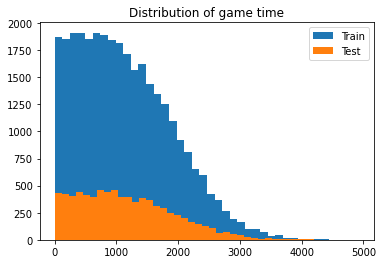

In [35]:
plt.hist(X_train['game_time'], bins=40, label='Train');
plt.hist(X_test['game_time'], bins=40, label='Test');
plt.title('Distribution of game time');
plt.legend();

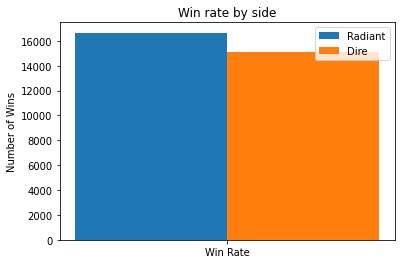

In [52]:
radiant_win,dire_win=y_train["radiant_win"].value_counts()



labels = ['Win Rate']
men_means = [radiant_win]
women_means = [dire_win]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Radiant')
rects2 = ax.bar(x + width/2, women_means, width, label='Dire')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of Wins')
ax.set_title('Win rate by side')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.show()




**Test logistic regression**

In [70]:
logit = LogisticRegression(C=1, solver='lbfgs', max_iter=500,
                           random_state=17, n_jobs=4,
                          multi_class='multinomial')
logit_pipe = Pipeline([('scaler', StandardScaler()),
                       ('logit', logit)])

In [71]:
%%time
logit_pipe.fit(X_train, y_train)
# this may take a while...

Wall time: 12.9 s


Pipeline(steps=[('scaler', StandardScaler()),
                ('logit',
                 LogisticRegression(C=1, max_iter=500,
                                    multi_class='multinomial', n_jobs=4,
                                    random_state=17))])

In [72]:
logit_val_pred = logit_pipe.predict(X_test)
accuracy_score(y_test, logit_val_pred)

0.7253938248267171

In [73]:
first_forest = RandomForestClassifier(
    n_estimators=100, random_state=17, n_jobs=4)

In [74]:
%%time
first_forest.fit(X_train, y_train)
# this may take a while... (17ss)

Wall time: 12.8 s


RandomForestClassifier(n_jobs=4, random_state=17)

In [75]:
forest_val_pred = first_forest.predict(X_test)
accuracy_score(y_test, forest_val_pred)

0.7039697542533081

In [76]:
pd.DataFrame(first_forest.feature_importances_,
             index=X_train.columns, columns=['Importance']).sort_values(
    by='Importance', ascending=False)[:10]

,Importance
time_remaining,0.019710
duration,0.019274
r2_gold,0.013470
r4_gold,0.013373
d1_gold,0.013368
r5_gold,0.013255
d5_gold,0.012913
d2_gold,0.012801
d3_gold,0.012584
d4_gold,0.012568


In [77]:
lgb_clf = LGBMClassifier(random_state=17)

In [78]:
%%time
lgb_clf.fit(X_train, y_train)

Wall time: 2.94 s


LGBMClassifier(random_state=17)

In [79]:
accuracy_score(y_test, lgb_clf.predict(X_test))

0.709640831758034

**1 stage of hyper-param tuning: tuning model complexity**

In [80]:
param_grid = {'num_leaves': [7, 15, 31, 63],
              'max_depth': [3, 4, 5, 6, -1]}

In [81]:
grid_searcher = GridSearchCV(estimator=lgb_clf, param_grid=param_grid,
                             cv=5, verbose=1, n_jobs=4)

In [82]:
grid_searcher.fit(X_train, y_train) # This may take a while!

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   43.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  1.7min finished


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=17), n_jobs=4,
             param_grid={'max_depth': [3, 4, 5, 6, -1],
                         'num_leaves': [7, 15, 31, 63]},
             verbose=1)

In [83]:
grid_searcher.best_params_, grid_searcher.best_score_

({'max_depth': -1, 'num_leaves': 63}, 0.710491493383743)

In [84]:
accuracy_score(y_test, grid_searcher.predict(X_test))

0.7085066162570889

**2 stage of hyper-param tuning: convergence:**

In [86]:
# This may take a while
num_iterations = 200
lgb_clf2 = LGBMClassifier(random_state=17, max_depth=-1,
                          num_leaves=63, n_estimators=num_iterations,
                          n_jobs=1)

param_grid2 = {'learning_rate': np.logspace(-3, 0, 10)}
grid_searcher2 = GridSearchCV(estimator=lgb_clf2, param_grid=param_grid2,
                               cv=5, verbose=1, n_jobs=4)
grid_searcher2.fit(X_train, y_train)
print(grid_searcher2.best_params_, grid_searcher2.best_score_)
print(accuracy_score(y_test, grid_searcher2.predict(X_test)))
# This may take very long !!! 6.3 min

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'learning_rate': 0.046415888336127774} 0.7129174543163203
0.7121613106490233


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.5min finished


In [89]:
final_lgb = LGBMClassifier(n_estimators=200, num_leaves=63,
                           learning_rate=0.1, max_depth=-1,
                         n_jobs=4)


In [90]:
%%time
final_lgb.fit(X_train, y_train)
# This may take some time

Wall time: 4.71 s


LGBMClassifier(n_estimators=200, n_jobs=4, num_leaves=63)

In [91]:
%%time
lgb_final_pred = final_lgb.predict(X_test)

Wall time: 97.7 ms


In [92]:
print(accuracy_score(y_test, lgb_final_pred))

0.7032136105860114
